<a href="https://colab.research.google.com/github/Aakriti28/Generative-Adversarial-Networks/blob/master/Vanilla_GAN_for_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [0]:
#Using GPU
print(sys.version)
device = 'cuda'
#Checking for GPU
print(torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.is_available())

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
10.1
1
True


In [0]:
def mnist_data():
  compose = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
  return datasets.MNIST(root='./data', train = True, transform=compose, download=True)

data = mnist_data()

batch = 128
data_loader = DataLoader(data, batch_size=batch, shuffle =True)
num_batches = len(data_loader)
print(num_batches)

469


torch.Size([128, 1, 28, 28])


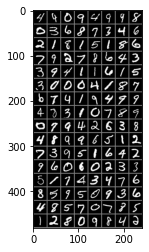

In [0]:
#display some images 
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  #plt.imshow(np.transpose(img, (1, 2, 0)))
  #print(img.shape)
  img =img/2 +0.5
  npimg = img.cpu().numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
  plt.show()

dataiter = iter(data_loader)
images, labels = dataiter.next()

print(images.shape)
imshow(torchvision.utils.make_grid(images))
#print(' '.join('%10s' % [labels[i]] for i in range(4)))

In [0]:
class DiscriminatorNet(torch.nn.Module):
  def __init__(self):
    super(DiscriminatorNet, self).__init__()
    self.hidden0 = nn.Sequential(
        nn.Linear(784, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    self.hidden1 = nn.Sequential(
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    self.hidden2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    self.out = nn.Sequential(
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.hidden0(x)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.out(x)
    return x

discriminator = DiscriminatorNet().to(device)
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002)

In [0]:
def images_to_vectors(images):
  return images.view(images.size(0), 784)

def vectors_to_images(vectors):
  return vectors.view(vectors.size(0), 1, 28, 28)

In [0]:
class GeneratorNet(torch.nn.Module):
  def __init__(self):
    super(GeneratorNet, self).__init__()
    self.hidden0 = nn.Sequential(
        nn.Linear(100, 256),
        nn.LeakyReLU(0.2)  
    )
    self.hidden1 = nn.Sequential(
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2)
    )
    self.hidden2 = nn.Sequential(
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2)
    )
    self.out = nn.Sequential(
        nn.Linear(1024, 784),
        nn.Tanh()
    )
    

  def forward(self, x):
    #print(x)
    x = self.hidden0(x)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.out(x)
    return x

generator = GeneratorNet().to(device)
g_optimizer = optim.Adam(generator.parameters(), lr = 0.0002)

loss = nn.BCELoss()

In [0]:
def noise(size):
  n = Variable(torch.randn(size, 100))
  return n.to(device)

In [0]:
def ones_target(size):
  data = Variable(torch.ones(size, 1))
  return data.to(device)

def zeros_target(size):
  data = Variable(torch.zeros(size, 1))
  return data.to(device)

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
  N = real_data.size(0)
  optimizer.zero_grad()

  prediction_real = discriminator(real_data).to(device)
  loss_real = loss(prediction_real, ones_target(N))
  loss_real.backward()

  prediction_fake = discriminator(fake_data).to(device)
  loss_fake = loss(prediction_fake, zeros_target(N))
  loss_fake.backward()

  optimizer.step()

  return loss_real+loss_fake, prediction_real, prediction_fake

In [0]:
def train_generator(optimizer, fake_data):
  N = fake_data.size(0)
  optimizer.zero_grad()

  prediction_fake = discriminator(fake_data).to(device)
  loss_gen = loss(prediction_fake, ones_target(N))
  loss_gen.backward()

  optimizer.step()

  return loss_gen

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [0]:
def fit(num_epochs = 200):
  G_losses = []
  D_losses = []
  for epoch in range(num_epochs):
    d_loss = 0
    g_loss = 0
    for num_iter, (real_batch, _) in enumerate(data_loader):
      #print(real_batch.size(0))
      N = real_batch.size(0)
      #print(noise(N))

      real_data = Variable(images_to_vectors(real_batch)).to(device)
      fake_data = generator(noise(N)).to(device)
      d_loss_now, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data.detach())
      d_loss += d_loss_now

      fake_data = generator(noise(N)).to(device)
      g_loss_now = train_generator(g_optimizer, fake_data)
      g_loss += g_loss_now

    D_losses.append(d_loss)
    G_losses.append(g_loss)
    print("Epoch no - " + str(epoch+1))
    print("Discriminator Loss : %f \t Generator_loss : %f" % (d_loss.item(), g_loss.item()))
    print("Accuracy on Real Data : %f \t Accuracy on fake Data : %f" % (d_pred_real.mean().item(), d_pred_fake.mean().item()))
    lr_scheduler.step(train_loss/len(train_dl))

    if((epoch+1)%10 ==0):
      with torch.no_grad():
        generated_data = generator(test_noise.detach())
        imshow(torchvision.utils.make_grid(vectors_to_images(generated_data)))

  plt.figure(figsize=(10,5))
  plt.title("Generator and Discriminator Loss During Training")
  plt.plot(G_losses,label="G")
  plt.plot(D_losses,label="D")
  plt.xlabel("iterations")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()
    


Epoch no - 1
Discriminator Loss : 302.075653 	 Generator_loss : 2124.071777
Accuracy on Real Data : 0.938088 	 Accuracy on fake Data : 0.143429
Epoch no - 2
Discriminator Loss : 342.490936 	 Generator_loss : 1777.440186
Accuracy on Real Data : 0.840264 	 Accuracy on fake Data : 0.232378
Epoch no - 3
Discriminator Loss : 414.224121 	 Generator_loss : 989.487610
Accuracy on Real Data : 0.824910 	 Accuracy on fake Data : 0.220677
Epoch no - 4
Discriminator Loss : 348.208740 	 Generator_loss : 1404.044678
Accuracy on Real Data : 0.918896 	 Accuracy on fake Data : 0.126447
Epoch no - 5
Discriminator Loss : 249.959381 	 Generator_loss : 1366.255249
Accuracy on Real Data : 0.895727 	 Accuracy on fake Data : 0.118895
Epoch no - 6
Discriminator Loss : 196.480972 	 Generator_loss : 1568.269287
Accuracy on Real Data : 0.891247 	 Accuracy on fake Data : 0.180910
Epoch no - 7
Discriminator Loss : 184.979568 	 Generator_loss : 1497.313477
Accuracy on Real Data : 0.898208 	 Accuracy on fake Data : 0.

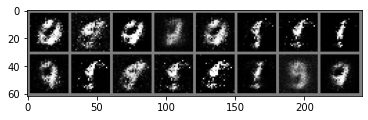

Epoch no - 11
Discriminator Loss : 224.998322 	 Generator_loss : 1443.292358
Accuracy on Real Data : 0.860967 	 Accuracy on fake Data : 0.202502
Epoch no - 12
Discriminator Loss : 249.944763 	 Generator_loss : 1273.068604
Accuracy on Real Data : 0.907237 	 Accuracy on fake Data : 0.274669
Epoch no - 13
Discriminator Loss : 258.520203 	 Generator_loss : 1218.508545
Accuracy on Real Data : 0.770533 	 Accuracy on fake Data : 0.169607
Epoch no - 14
Discriminator Loss : 284.289337 	 Generator_loss : 1147.038452
Accuracy on Real Data : 0.806103 	 Accuracy on fake Data : 0.179157
Epoch no - 15
Discriminator Loss : 302.760803 	 Generator_loss : 1055.092285
Accuracy on Real Data : 0.806231 	 Accuracy on fake Data : 0.216302
Epoch no - 16
Discriminator Loss : 319.781158 	 Generator_loss : 1018.108765
Accuracy on Real Data : 0.815420 	 Accuracy on fake Data : 0.212826
Epoch no - 17
Discriminator Loss : 319.460846 	 Generator_loss : 1034.320801
Accuracy on Real Data : 0.849102 	 Accuracy on fake D

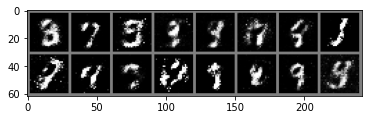

Epoch no - 21
Discriminator Loss : 366.135162 	 Generator_loss : 912.774414
Accuracy on Real Data : 0.708374 	 Accuracy on fake Data : 0.266131
Epoch no - 22
Discriminator Loss : 389.830505 	 Generator_loss : 837.104492
Accuracy on Real Data : 0.672834 	 Accuracy on fake Data : 0.334259
Epoch no - 23
Discriminator Loss : 405.344910 	 Generator_loss : 810.740967
Accuracy on Real Data : 0.660819 	 Accuracy on fake Data : 0.365759
Epoch no - 24
Discriminator Loss : 408.227875 	 Generator_loss : 818.411743
Accuracy on Real Data : 0.673329 	 Accuracy on fake Data : 0.444738
Epoch no - 25
Discriminator Loss : 402.305206 	 Generator_loss : 802.970947
Accuracy on Real Data : 0.747312 	 Accuracy on fake Data : 0.290009
Epoch no - 26
Discriminator Loss : 415.941071 	 Generator_loss : 795.672241
Accuracy on Real Data : 0.747465 	 Accuracy on fake Data : 0.281778
Epoch no - 27
Discriminator Loss : 411.377258 	 Generator_loss : 799.852173
Accuracy on Real Data : 0.712512 	 Accuracy on fake Data : 0

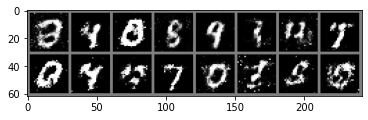

Epoch no - 31
Discriminator Loss : 438.719116 	 Generator_loss : 722.386597
Accuracy on Real Data : 0.739769 	 Accuracy on fake Data : 0.300120
Epoch no - 32
Discriminator Loss : 445.869141 	 Generator_loss : 708.366028
Accuracy on Real Data : 0.699509 	 Accuracy on fake Data : 0.399994
Epoch no - 33
Discriminator Loss : 442.088257 	 Generator_loss : 718.374146
Accuracy on Real Data : 0.700086 	 Accuracy on fake Data : 0.214714
Epoch no - 34
Discriminator Loss : 459.783508 	 Generator_loss : 682.100952
Accuracy on Real Data : 0.642268 	 Accuracy on fake Data : 0.415978
Epoch no - 35
Discriminator Loss : 456.782898 	 Generator_loss : 680.133423
Accuracy on Real Data : 0.654836 	 Accuracy on fake Data : 0.358879
Epoch no - 36
Discriminator Loss : 463.181976 	 Generator_loss : 671.715027
Accuracy on Real Data : 0.737075 	 Accuracy on fake Data : 0.270109
Epoch no - 37
Discriminator Loss : 460.835938 	 Generator_loss : 670.383484
Accuracy on Real Data : 0.677905 	 Accuracy on fake Data : 0

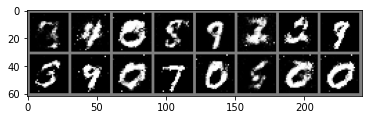

Epoch no - 41
Discriminator Loss : 481.817139 	 Generator_loss : 631.237061
Accuracy on Real Data : 0.722255 	 Accuracy on fake Data : 0.292395
Epoch no - 42
Discriminator Loss : 485.119415 	 Generator_loss : 639.315918
Accuracy on Real Data : 0.718515 	 Accuracy on fake Data : 0.281214
Epoch no - 43
Discriminator Loss : 495.863861 	 Generator_loss : 603.942139
Accuracy on Real Data : 0.649952 	 Accuracy on fake Data : 0.313297
Epoch no - 44
Discriminator Loss : 496.411804 	 Generator_loss : 606.665161
Accuracy on Real Data : 0.638062 	 Accuracy on fake Data : 0.343424
Epoch no - 45
Discriminator Loss : 489.291962 	 Generator_loss : 615.529785
Accuracy on Real Data : 0.617149 	 Accuracy on fake Data : 0.296599
Epoch no - 46
Discriminator Loss : 492.189911 	 Generator_loss : 621.863159
Accuracy on Real Data : 0.614482 	 Accuracy on fake Data : 0.462593
Epoch no - 47
Discriminator Loss : 499.544861 	 Generator_loss : 593.614258
Accuracy on Real Data : 0.651158 	 Accuracy on fake Data : 0

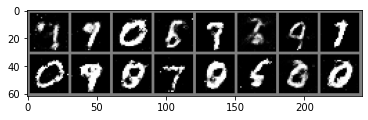

Epoch no - 51
Discriminator Loss : 510.469940 	 Generator_loss : 586.226440
Accuracy on Real Data : 0.624458 	 Accuracy on fake Data : 0.387625
Epoch no - 52
Discriminator Loss : 512.610046 	 Generator_loss : 572.689880
Accuracy on Real Data : 0.686952 	 Accuracy on fake Data : 0.312635
Epoch no - 53
Discriminator Loss : 515.329712 	 Generator_loss : 568.494385
Accuracy on Real Data : 0.571956 	 Accuracy on fake Data : 0.384371
Epoch no - 54
Discriminator Loss : 516.204834 	 Generator_loss : 560.924072
Accuracy on Real Data : 0.663639 	 Accuracy on fake Data : 0.347621
Epoch no - 55
Discriminator Loss : 520.067993 	 Generator_loss : 556.454468
Accuracy on Real Data : 0.630964 	 Accuracy on fake Data : 0.386803
Epoch no - 56
Discriminator Loss : 522.782166 	 Generator_loss : 554.734863
Accuracy on Real Data : 0.569048 	 Accuracy on fake Data : 0.410683
Epoch no - 57
Discriminator Loss : 531.725952 	 Generator_loss : 531.468079
Accuracy on Real Data : 0.639114 	 Accuracy on fake Data : 0

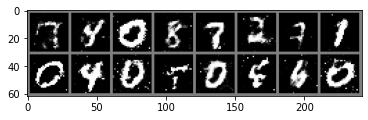

Epoch no - 61
Discriminator Loss : 534.453613 	 Generator_loss : 531.255005
Accuracy on Real Data : 0.631416 	 Accuracy on fake Data : 0.391850
Epoch no - 62
Discriminator Loss : 538.723694 	 Generator_loss : 535.072937
Accuracy on Real Data : 0.582931 	 Accuracy on fake Data : 0.437700
Epoch no - 63
Discriminator Loss : 536.874573 	 Generator_loss : 522.867249
Accuracy on Real Data : 0.654799 	 Accuracy on fake Data : 0.390235
Epoch no - 64
Discriminator Loss : 538.398560 	 Generator_loss : 527.956604
Accuracy on Real Data : 0.584857 	 Accuracy on fake Data : 0.405889
Epoch no - 65
Discriminator Loss : 537.963562 	 Generator_loss : 523.214355
Accuracy on Real Data : 0.631090 	 Accuracy on fake Data : 0.420082
Epoch no - 66
Discriminator Loss : 544.784302 	 Generator_loss : 507.689453
Accuracy on Real Data : 0.586935 	 Accuracy on fake Data : 0.385942
Epoch no - 67
Discriminator Loss : 542.410950 	 Generator_loss : 515.672974
Accuracy on Real Data : 0.533186 	 Accuracy on fake Data : 0

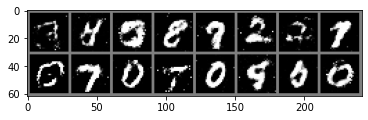

Epoch no - 71
Discriminator Loss : 556.780884 	 Generator_loss : 489.544647
Accuracy on Real Data : 0.622435 	 Accuracy on fake Data : 0.354601
Epoch no - 72
Discriminator Loss : 555.142883 	 Generator_loss : 490.523499
Accuracy on Real Data : 0.651450 	 Accuracy on fake Data : 0.402048
Epoch no - 73
Discriminator Loss : 558.624756 	 Generator_loss : 483.295013
Accuracy on Real Data : 0.591237 	 Accuracy on fake Data : 0.389405
Epoch no - 74
Discriminator Loss : 557.558716 	 Generator_loss : 493.532288
Accuracy on Real Data : 0.621939 	 Accuracy on fake Data : 0.382197
Epoch no - 75
Discriminator Loss : 552.337463 	 Generator_loss : 502.124756
Accuracy on Real Data : 0.633286 	 Accuracy on fake Data : 0.401452
Epoch no - 76
Discriminator Loss : 555.887695 	 Generator_loss : 493.175262
Accuracy on Real Data : 0.586510 	 Accuracy on fake Data : 0.350252
Epoch no - 77
Discriminator Loss : 555.611084 	 Generator_loss : 495.946533
Accuracy on Real Data : 0.599832 	 Accuracy on fake Data : 0

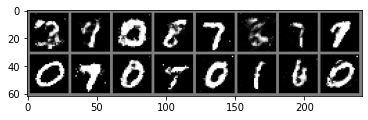

Epoch no - 81
Discriminator Loss : 554.030396 	 Generator_loss : 495.038879
Accuracy on Real Data : 0.571885 	 Accuracy on fake Data : 0.415479
Epoch no - 82
Discriminator Loss : 561.328491 	 Generator_loss : 484.043671
Accuracy on Real Data : 0.545695 	 Accuracy on fake Data : 0.417569
Epoch no - 83
Discriminator Loss : 563.682922 	 Generator_loss : 477.307953
Accuracy on Real Data : 0.609100 	 Accuracy on fake Data : 0.410412
Epoch no - 84
Discriminator Loss : 561.654114 	 Generator_loss : 482.361084
Accuracy on Real Data : 0.570515 	 Accuracy on fake Data : 0.368846
Epoch no - 85
Discriminator Loss : 563.149170 	 Generator_loss : 478.176849
Accuracy on Real Data : 0.623198 	 Accuracy on fake Data : 0.377199
Epoch no - 86
Discriminator Loss : 565.953186 	 Generator_loss : 476.903229
Accuracy on Real Data : 0.586678 	 Accuracy on fake Data : 0.393672
Epoch no - 87
Discriminator Loss : 571.032898 	 Generator_loss : 465.076599
Accuracy on Real Data : 0.579094 	 Accuracy on fake Data : 0

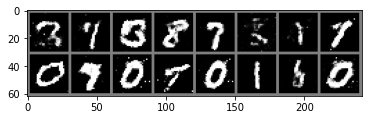

Epoch no - 91
Discriminator Loss : 570.496094 	 Generator_loss : 468.217194
Accuracy on Real Data : 0.591059 	 Accuracy on fake Data : 0.402511
Epoch no - 92
Discriminator Loss : 574.851501 	 Generator_loss : 462.145599
Accuracy on Real Data : 0.527606 	 Accuracy on fake Data : 0.446140
Epoch no - 93
Discriminator Loss : 577.503052 	 Generator_loss : 457.250397
Accuracy on Real Data : 0.614212 	 Accuracy on fake Data : 0.457309
Epoch no - 94
Discriminator Loss : 571.110535 	 Generator_loss : 461.300690
Accuracy on Real Data : 0.631620 	 Accuracy on fake Data : 0.422447
Epoch no - 95
Discriminator Loss : 573.458618 	 Generator_loss : 458.306641
Accuracy on Real Data : 0.593029 	 Accuracy on fake Data : 0.420679
Epoch no - 96
Discriminator Loss : 577.946716 	 Generator_loss : 458.850555
Accuracy on Real Data : 0.521997 	 Accuracy on fake Data : 0.397713
Epoch no - 97
Discriminator Loss : 575.403625 	 Generator_loss : 462.883667
Accuracy on Real Data : 0.587944 	 Accuracy on fake Data : 0

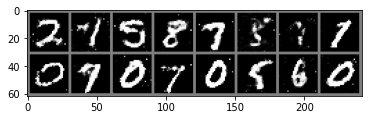

Epoch no - 101
Discriminator Loss : 580.058594 	 Generator_loss : 453.275330
Accuracy on Real Data : 0.581636 	 Accuracy on fake Data : 0.373610
Epoch no - 102
Discriminator Loss : 578.177612 	 Generator_loss : 457.242310
Accuracy on Real Data : 0.643164 	 Accuracy on fake Data : 0.408491
Epoch no - 103
Discriminator Loss : 583.653870 	 Generator_loss : 444.392365
Accuracy on Real Data : 0.545236 	 Accuracy on fake Data : 0.409109
Epoch no - 104
Discriminator Loss : 581.617126 	 Generator_loss : 451.252563
Accuracy on Real Data : 0.606518 	 Accuracy on fake Data : 0.431858
Epoch no - 105
Discriminator Loss : 580.341003 	 Generator_loss : 456.240875
Accuracy on Real Data : 0.471025 	 Accuracy on fake Data : 0.446334
Epoch no - 106
Discriminator Loss : 578.425659 	 Generator_loss : 452.817291
Accuracy on Real Data : 0.552225 	 Accuracy on fake Data : 0.470155
Epoch no - 107
Discriminator Loss : 574.363342 	 Generator_loss : 461.592133
Accuracy on Real Data : 0.583495 	 Accuracy on fake D

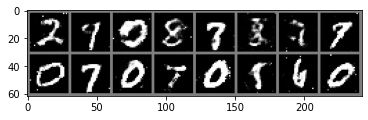

Epoch no - 111
Discriminator Loss : 581.238342 	 Generator_loss : 448.001373
Accuracy on Real Data : 0.621046 	 Accuracy on fake Data : 0.458003
Epoch no - 112
Discriminator Loss : 581.444580 	 Generator_loss : 443.864014
Accuracy on Real Data : 0.579118 	 Accuracy on fake Data : 0.403143
Epoch no - 113
Discriminator Loss : 582.691895 	 Generator_loss : 450.989563
Accuracy on Real Data : 0.605152 	 Accuracy on fake Data : 0.476643
Epoch no - 114
Discriminator Loss : 584.778076 	 Generator_loss : 448.527832
Accuracy on Real Data : 0.571235 	 Accuracy on fake Data : 0.430554
Epoch no - 115
Discriminator Loss : 582.107056 	 Generator_loss : 450.616486
Accuracy on Real Data : 0.602129 	 Accuracy on fake Data : 0.391193
Epoch no - 116
Discriminator Loss : 576.903076 	 Generator_loss : 455.733124
Accuracy on Real Data : 0.594529 	 Accuracy on fake Data : 0.422927
Epoch no - 117
Discriminator Loss : 579.848389 	 Generator_loss : 451.485962
Accuracy on Real Data : 0.586857 	 Accuracy on fake D

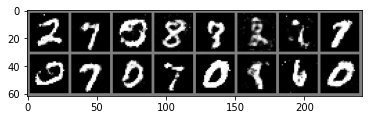

Epoch no - 121
Discriminator Loss : 588.623291 	 Generator_loss : 443.802429
Accuracy on Real Data : 0.569105 	 Accuracy on fake Data : 0.440573
Epoch no - 122
Discriminator Loss : 590.099365 	 Generator_loss : 435.898926
Accuracy on Real Data : 0.572321 	 Accuracy on fake Data : 0.417107
Epoch no - 123
Discriminator Loss : 591.866028 	 Generator_loss : 431.905212
Accuracy on Real Data : 0.551501 	 Accuracy on fake Data : 0.454378
Epoch no - 124
Discriminator Loss : 590.157593 	 Generator_loss : 437.330872
Accuracy on Real Data : 0.554603 	 Accuracy on fake Data : 0.452878
Epoch no - 125
Discriminator Loss : 587.662354 	 Generator_loss : 443.373413
Accuracy on Real Data : 0.599981 	 Accuracy on fake Data : 0.433883
Epoch no - 126
Discriminator Loss : 588.120483 	 Generator_loss : 437.311035
Accuracy on Real Data : 0.529136 	 Accuracy on fake Data : 0.433910
Epoch no - 127
Discriminator Loss : 585.824158 	 Generator_loss : 444.428467
Accuracy on Real Data : 0.575744 	 Accuracy on fake D

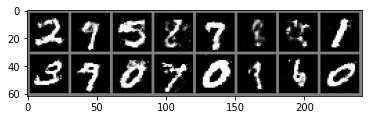

Epoch no - 131
Discriminator Loss : 589.500305 	 Generator_loss : 441.452637
Accuracy on Real Data : 0.573528 	 Accuracy on fake Data : 0.416072
Epoch no - 132
Discriminator Loss : 591.747314 	 Generator_loss : 429.557648
Accuracy on Real Data : 0.555274 	 Accuracy on fake Data : 0.450021
Epoch no - 133
Discriminator Loss : 591.487366 	 Generator_loss : 433.591797
Accuracy on Real Data : 0.624280 	 Accuracy on fake Data : 0.435459
Epoch no - 134
Discriminator Loss : 590.772034 	 Generator_loss : 433.566101
Accuracy on Real Data : 0.542441 	 Accuracy on fake Data : 0.437593
Epoch no - 135
Discriminator Loss : 593.451111 	 Generator_loss : 435.554382
Accuracy on Real Data : 0.529534 	 Accuracy on fake Data : 0.392744
Epoch no - 136
Discriminator Loss : 593.298218 	 Generator_loss : 435.565491
Accuracy on Real Data : 0.560631 	 Accuracy on fake Data : 0.420035
Epoch no - 137
Discriminator Loss : 585.925293 	 Generator_loss : 447.538635
Accuracy on Real Data : 0.608606 	 Accuracy on fake D

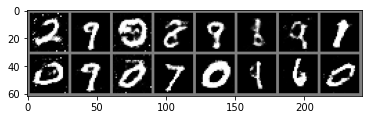

Epoch no - 141
Discriminator Loss : 591.982971 	 Generator_loss : 434.531250
Accuracy on Real Data : 0.557717 	 Accuracy on fake Data : 0.443469
Epoch no - 142
Discriminator Loss : 595.851379 	 Generator_loss : 422.291321
Accuracy on Real Data : 0.583018 	 Accuracy on fake Data : 0.484781
Epoch no - 143
Discriminator Loss : 590.198242 	 Generator_loss : 438.520966
Accuracy on Real Data : 0.504972 	 Accuracy on fake Data : 0.432613
Epoch no - 144
Discriminator Loss : 591.655273 	 Generator_loss : 432.029480
Accuracy on Real Data : 0.614583 	 Accuracy on fake Data : 0.436166
Epoch no - 145
Discriminator Loss : 592.532043 	 Generator_loss : 429.478424
Accuracy on Real Data : 0.541116 	 Accuracy on fake Data : 0.448576
Epoch no - 146
Discriminator Loss : 597.626038 	 Generator_loss : 421.900452
Accuracy on Real Data : 0.542676 	 Accuracy on fake Data : 0.469999
Epoch no - 147
Discriminator Loss : 597.295837 	 Generator_loss : 430.569519
Accuracy on Real Data : 0.524607 	 Accuracy on fake D

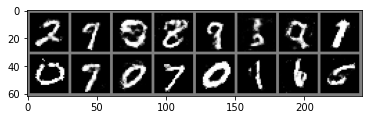

Epoch no - 151
Discriminator Loss : 592.372192 	 Generator_loss : 428.854584
Accuracy on Real Data : 0.583761 	 Accuracy on fake Data : 0.415306
Epoch no - 152
Discriminator Loss : 593.291687 	 Generator_loss : 434.295410
Accuracy on Real Data : 0.569415 	 Accuracy on fake Data : 0.409051
Epoch no - 153
Discriminator Loss : 589.181824 	 Generator_loss : 439.561218
Accuracy on Real Data : 0.523364 	 Accuracy on fake Data : 0.388708
Epoch no - 154
Discriminator Loss : 592.606873 	 Generator_loss : 427.189056
Accuracy on Real Data : 0.575723 	 Accuracy on fake Data : 0.463721
Epoch no - 155
Discriminator Loss : 596.047302 	 Generator_loss : 421.387390
Accuracy on Real Data : 0.517685 	 Accuracy on fake Data : 0.462592
Epoch no - 156
Discriminator Loss : 594.385193 	 Generator_loss : 425.179993
Accuracy on Real Data : 0.497070 	 Accuracy on fake Data : 0.422883
Epoch no - 157
Discriminator Loss : 595.108215 	 Generator_loss : 424.377991
Accuracy on Real Data : 0.528087 	 Accuracy on fake D

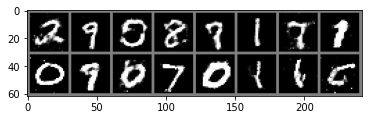

Epoch no - 161
Discriminator Loss : 596.451843 	 Generator_loss : 422.326294
Accuracy on Real Data : 0.537054 	 Accuracy on fake Data : 0.389316
Epoch no - 162
Discriminator Loss : 593.941772 	 Generator_loss : 430.077087
Accuracy on Real Data : 0.533516 	 Accuracy on fake Data : 0.404039
Epoch no - 163
Discriminator Loss : 597.748962 	 Generator_loss : 421.222229
Accuracy on Real Data : 0.540580 	 Accuracy on fake Data : 0.440002
Epoch no - 164
Discriminator Loss : 594.562683 	 Generator_loss : 426.470886
Accuracy on Real Data : 0.568628 	 Accuracy on fake Data : 0.401466
Epoch no - 165
Discriminator Loss : 597.955688 	 Generator_loss : 417.287109
Accuracy on Real Data : 0.543779 	 Accuracy on fake Data : 0.445616
Epoch no - 166
Discriminator Loss : 597.050720 	 Generator_loss : 422.799988
Accuracy on Real Data : 0.585472 	 Accuracy on fake Data : 0.470039
Epoch no - 167
Discriminator Loss : 593.734985 	 Generator_loss : 427.649567
Accuracy on Real Data : 0.546100 	 Accuracy on fake D

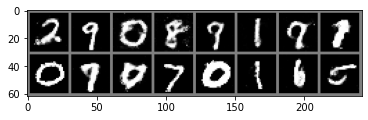

Epoch no - 171
Discriminator Loss : 598.891174 	 Generator_loss : 416.656281
Accuracy on Real Data : 0.513310 	 Accuracy on fake Data : 0.460313
Epoch no - 172
Discriminator Loss : 599.407898 	 Generator_loss : 414.647186
Accuracy on Real Data : 0.527142 	 Accuracy on fake Data : 0.442659
Epoch no - 173
Discriminator Loss : 599.633484 	 Generator_loss : 416.327576
Accuracy on Real Data : 0.548931 	 Accuracy on fake Data : 0.470087
Epoch no - 174
Discriminator Loss : 600.084106 	 Generator_loss : 414.455261
Accuracy on Real Data : 0.548171 	 Accuracy on fake Data : 0.499834
Epoch no - 175
Discriminator Loss : 592.122314 	 Generator_loss : 433.026489
Accuracy on Real Data : 0.543094 	 Accuracy on fake Data : 0.402787
Epoch no - 176
Discriminator Loss : 597.168579 	 Generator_loss : 421.950195
Accuracy on Real Data : 0.551610 	 Accuracy on fake Data : 0.453619
Epoch no - 177
Discriminator Loss : 598.138550 	 Generator_loss : 422.402832
Accuracy on Real Data : 0.597362 	 Accuracy on fake D

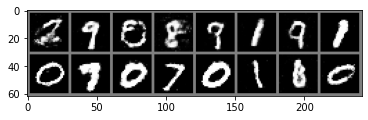

Epoch no - 181
Discriminator Loss : 599.777344 	 Generator_loss : 421.088928
Accuracy on Real Data : 0.541465 	 Accuracy on fake Data : 0.448775
Epoch no - 182
Discriminator Loss : 597.295898 	 Generator_loss : 417.218994
Accuracy on Real Data : 0.612497 	 Accuracy on fake Data : 0.414679
Epoch no - 183
Discriminator Loss : 600.552002 	 Generator_loss : 420.522217
Accuracy on Real Data : 0.566068 	 Accuracy on fake Data : 0.461236
Epoch no - 184
Discriminator Loss : 598.302734 	 Generator_loss : 413.662231
Accuracy on Real Data : 0.570513 	 Accuracy on fake Data : 0.419194
Epoch no - 185
Discriminator Loss : 599.357239 	 Generator_loss : 420.836884
Accuracy on Real Data : 0.540433 	 Accuracy on fake Data : 0.458500
Epoch no - 186
Discriminator Loss : 600.028931 	 Generator_loss : 414.262482
Accuracy on Real Data : 0.604986 	 Accuracy on fake Data : 0.457294
Epoch no - 187
Discriminator Loss : 597.130066 	 Generator_loss : 425.755310
Accuracy on Real Data : 0.555123 	 Accuracy on fake D

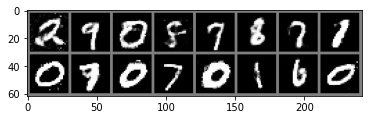

Epoch no - 191
Discriminator Loss : 600.083801 	 Generator_loss : 419.366028
Accuracy on Real Data : 0.482849 	 Accuracy on fake Data : 0.396042
Epoch no - 192
Discriminator Loss : 603.755554 	 Generator_loss : 409.388245
Accuracy on Real Data : 0.583429 	 Accuracy on fake Data : 0.454331
Epoch no - 193
Discriminator Loss : 603.045044 	 Generator_loss : 412.460205
Accuracy on Real Data : 0.515421 	 Accuracy on fake Data : 0.425634
Epoch no - 194
Discriminator Loss : 597.810486 	 Generator_loss : 418.435730
Accuracy on Real Data : 0.534331 	 Accuracy on fake Data : 0.463183
Epoch no - 195
Discriminator Loss : 601.962708 	 Generator_loss : 412.321320
Accuracy on Real Data : 0.552516 	 Accuracy on fake Data : 0.448889
Epoch no - 196
Discriminator Loss : 599.468140 	 Generator_loss : 419.832092
Accuracy on Real Data : 0.572902 	 Accuracy on fake Data : 0.442939
Epoch no - 197
Discriminator Loss : 604.912659 	 Generator_loss : 407.772736
Accuracy on Real Data : 0.541601 	 Accuracy on fake D

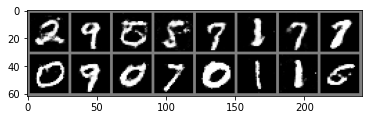

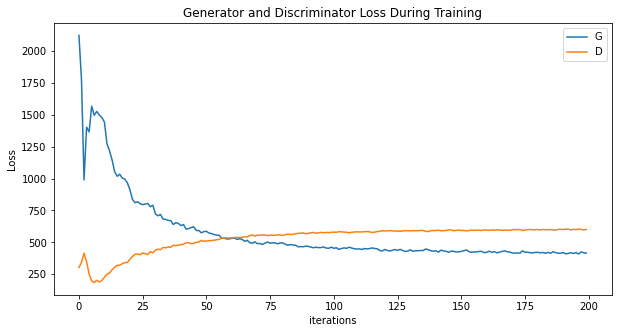

In [0]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4, verbose=True, eps = 10e-10)
fit()